In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv('/content/DATA UPTO 2021 CWC - Cleaned.csv')
df = df.set_index('DATE')
df.index = pd.to_datetime(df.index, dayfirst = True)
df.head

<bound method NDFrame.head of             RAPE   SEXUAL HARASSMENT   CRUELTY BY HUSBAND AND RELATIVES   \
DATE                                                                       
2010-01-01      1                   0                                  1   
2010-01-02      4                   1                                  2   
2010-01-03      1                   0                                  4   
2010-01-04      2                   0                                  8   
2010-01-05      1                   0                                  8   
...           ...                 ...                                ...   
2022-12-27      0                   0                                  1   
2022-12-28      0                   0                                  5   
2022-12-29      0                   4                                  8   
2022-12-30      1                   3                                  6   
2022-12-31      2                   2                     

In [ ]:
df_c =  df['CRUELTY BY HUSBAND AND RELATIVES ']
df_c.index = pd.to_datetime(df_c.index , dayfirst= True)

In [ ]:
df_c = pd.DataFrame(df_c).T
df_c.head()

DATE,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
CRUELTY BY HUSBAND AND RELATIVES,1,2,4,8,8,1,6,3,6,3,...,10,8,3,2,2,1,5,8,6,4


<Axes: ylabel='Frequency'>

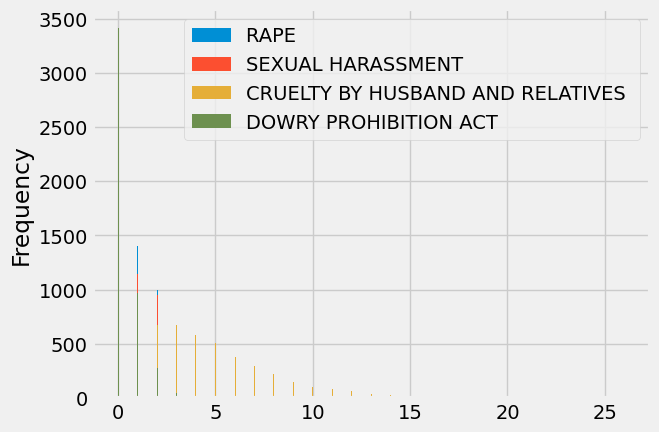

In [ ]:
df.plot(kind='hist', bins=500)

In [ ]:
train = df.loc[df.index < '01-01-2020']
test = df.loc[df.index >= '01-01-2020']

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'CRUELTY BY HUSBAND AND RELATIVES '

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[13:02:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.55162	validation_1-rmse:2.96183
[100]	validation_0-rmse:3.33714	validation_1-rmse:2.21783
[200]	validation_0-rmse:2.86958	validation_1-rmse:2.08529
[300]	validation_0-rmse:2.77351	validation_1-rmse:2.07152
[327]	validation_0-rmse:2.76180	validation_1-rmse:2.07345


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

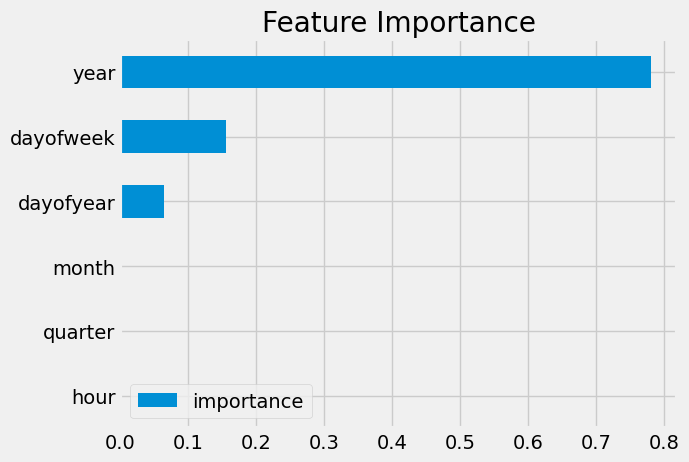

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

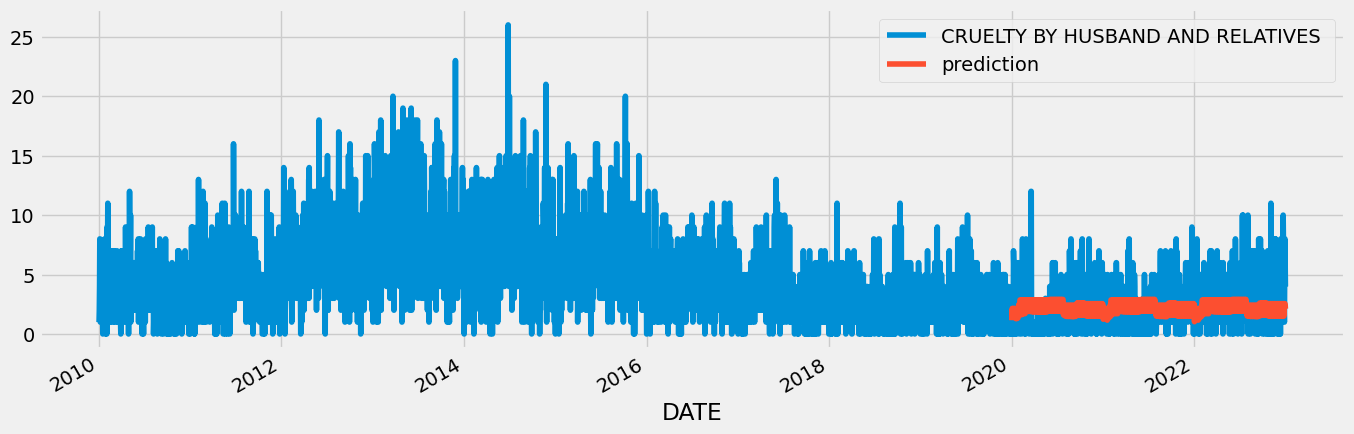

In [ ]:
test['prediction'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)
_ = all[['CRUELTY BY HUSBAND AND RELATIVES ','prediction']].plot(figsize=(15, 5))

In [ ]:
score = np.sqrt(mean_squared_error(test['CRUELTY BY HUSBAND AND RELATIVES '], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2.07


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(y_true=test['CRUELTY BY HUSBAND AND RELATIVES '],y_pred=test['prediction'])

1.6391843223441256

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=test['CRUELTY BY HUSBAND AND RELATIVES '], y_pred=test['prediction'])

<ipython-input-75-4a17b9aaf629>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


inf

In [ ]:
def wmape(actual, forecast):

    se_mape = abs(actual-forecast)/actual
    ft_actual_sum = actual.sum()
    se_actual_prod_mape = actual * se_mape

    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    return ft_wmape_forecast

wmape(test['CRUELTY BY HUSBAND AND RELATIVES '],test['prediction'])

0.46900433128319896

In [ ]:
df_r =  df['RAPE ']
df_r.index = pd.to_datetime(df_r.index , dayfirst= True)
df_r = pd.DataFrame(df_r).T
df_r.head()

DATE,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
RAPE,1,4,1,2,1,0,3,2,1,3,...,1,1,2,0,0,0,0,0,1,2


In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'RAPE '

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[13:04:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.73953	validation_1-rmse:1.49495
[100]	validation_0-rmse:1.99242	validation_1-rmse:1.32130
[200]	validation_0-rmse:1.83557	validation_1-rmse:1.29869
[249]	validation_0-rmse:1.80477	validation_1-rmse:1.30604


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

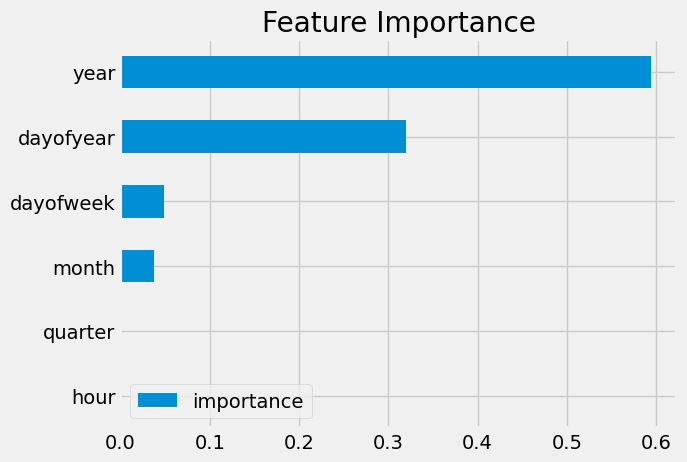

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

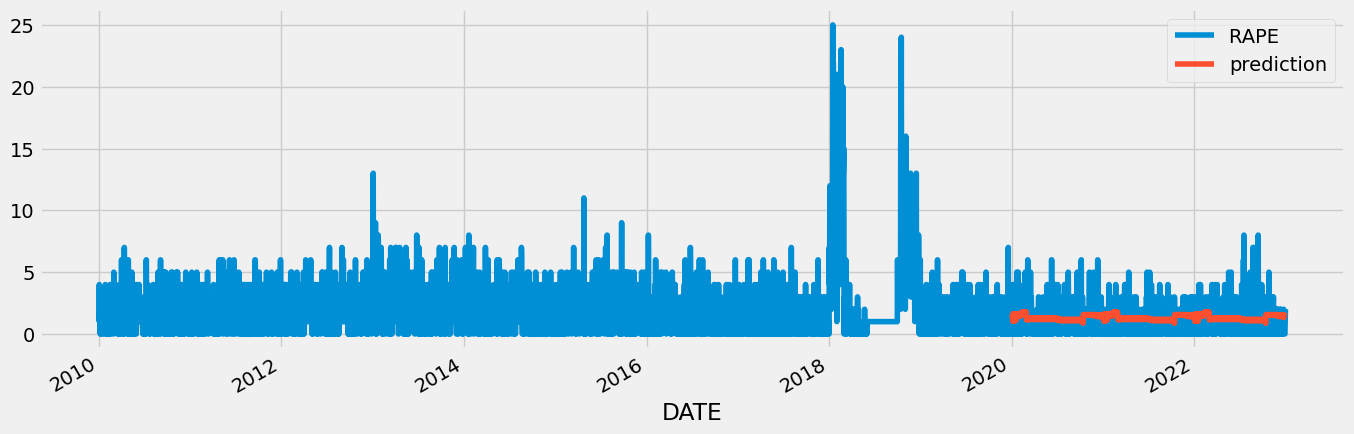

In [ ]:
test['prediction'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)
_ = all[['RAPE ','prediction']].plot(figsize=(15, 5))

In [ ]:
score = np.sqrt(mean_squared_error(test['RAPE '], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.30


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(y_true=test['RAPE '],y_pred=test['prediction'])

1.0146918941261995

In [ ]:
def wmape(actual, forecast):
    se_mape = abs(actual-forecast)/actual
    ft_actual_sum = actual.sum()
    se_actual_prod_mape = actual * se_mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    return ft_wmape_forecast

wmape(test['RAPE '],test['prediction'])

0.46737144630675936